## Análisis y Visualición de los datos

Los grandes conjuntos de datos que son muy heterogéneas en la composición de sus imágenes probablemente representen una descripción más ajustada de la realidad en la que se vaya a desempeñar el modelo (he allí una de las razones por la cual es necesaria una granc antidad de datos), lo que a su vez también implica un mayor desafío para el modelo (probablemente cueste más lograr que el modelo se desempeñe según lo esperado).

Como contrapartida, un conjunto de imágenes muy homogéneas probablemente muestre un buen desempeño en ese conjunto de datos con menor esfuerzo de entrenamiento, pero muy seguramente tenga dificultades para desemepeñarse de manera adecuada en imágenes de otra distribución o una composición diferente.

Es por ello que es una tarea crucial la selección de las imágenes que componen el conjunto de datos, y especialmente las que se seleccionan para el conjunto de pruebas (test). Idealmente las imágenes deben estar equitativamente balanceadas respecto de las composición (o distribución) en la que se empleará el modelo.

Fiftyone ofrece un conjunto de herramientas en su módulo Brain que facilitará la evaluación de los datos desde diferentes perspectivas de análisis.

Link a la documentación de [FiftyoneBrain](https://docs.voxel51.com/brain.html)

In [ ]:
# Para computar la reducción de dimensionalidad, es necesario instalar la librería UMAP
! pip install umap-learn --quiet

# Necesitamos torch y torchvision para cargar el modelo y computar los embeddings
! pip install torch torchvision --quiet

# Para visualizar el gráfico de unicidad
! pip install anywidget --quiet

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

## Cargar un dataset

In [ ]:
ds_name = "seeds_img_splits"
ds = fo.load_dataset(ds_name)

## Análisis de básico de Imágenes

El siguiente análisis aplica una método algorítmico de hashing para computar imágenes duplicadas.

### Duplicados exactos

In [ ]:
duplicates_map = fob.compute_exact_duplicates(ds)

In [ ]:
if not duplicates_map:
    print("No se encontraron duplicados.")
else:
    print(f"Se encontraron {len(duplicates_map)} duplicados.")

**EJERCICIO 1**: Escriba el código para marcar (tag) las muestras (samples) que se detectaron como duplicadas de otras.

In [ ]:
# Ejercicio 01.1 aquí

## Análisis de Imágenes basados en embeddings

### Embeddings

El embedding de una imagen es una representación numérica que condensa su contenido semántico. En redes convolucionales, esta información se captura a la salida de las capas convolucionales, que extraen las características más relevantes para la tarea del modelo. Estos mapas de características, usualmente volúmenes (arreglos multidimensionales), se transforman en vectores unidimensionales en espacios n-dimensionales.

Por ejemplo, una salida de 10×10×10, reordenando los datos del volumen de forma consecutiva, puede convertirse en un vector de 1000 valores. Esta operación se conoce como flatten (achatamiento) y en torch puede verse se implementado a través de la función *view*.

Como estos vectores provienen de operaciones como convoluciones y pooling, podemos interpretar que cada posición representa una característica aprendida por el modelo, y su valor indica magnitud de dicha característica en la imagen.

Así, imágenes similares pueden compartir los valores de aquellas magnitudes para ciertas características. Imágenes idénticas producen el mismo vector; imágenes distintas generan vectores con mayor o menor distancia en el espacio n-dimensional. La distancia euclidiana puede medir esta similitud, pero distancias como la del coseno, basada en el ángulo entre vectores, suelen capturarla mejor en espacios de alta dimensión.

Dada la imposibilidad de graficar espacios n-dimensionales, es necesario reducir esa alta dimensionalidad a un plano para poder respresentarlo visualmente y analizar los datos. Una de las cuestiones claves es observar si los datos de la misma clase tieneden a agruparse en sus propios conjuntos (clusters). Por otro lado, es importante remarcar no siempre una representación gráfica de este tipo, bi o tridimensional, implica el éxito o el fracaso del entrenamiento, dado que al reducir la representación de la información de un espacio de 1024 (por ejemplo) a 2 dimensiones, puede haber alguna pérdida de información que no represente fielmente lo que ocurre en el espacio de alta dimensionalidad. Es importante probar con diferentes métodos de reducción de dimensionalidad, y observar cómo las clases en clústers, su cercanía, y cómo el modelo efectivamente realiza las predicciones.
Fiftyone ofrece algunos de los métodos de reducción de dimensionalidad para esta tarea, tales como  *umap*, *tsne*, *pca*, entre otros. A partir de la construcción del espacio vectorial y consecuente reducción dimensional, se puede generar un índice para facilitar las tareas de búsqueda, comparación y su consecuente representación gráfica.

El [model-zoo de fiftyone](https://docs.voxel51.com/model_zoo/models.html) permite acceder a modelos preentrenados en grándes volúmenes de datos que frecuentemente son adecuados para generar embeddings. Además, proveen las interfaces necesarias para operar de manera casi transparente sobre los datos.

In [ ]:
# foz_model_name = "mobilenet-v2-imagenet-torch"
foz_model_name = "resnet18-imagenet-torch"

In [ ]:
# Elimino todas las ejecuciones anteriores
ds.delete_brain_runs()

Cargamos el modelo desde el zoo, y lo utilizamos para generar los embeddings

In [ ]:

model = foz.load_zoo_model(foz_model_name)
embeddings = ds.compute_embeddings(model)

El cómputo de la visualisación genera un índice dentro de una instancia de [VisualizationResults](https://docs.voxel51.com/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.VisualizationResults), que permite visualizar los embeddings en la aplicación de fiftyone.

In [ ]:
bk_visualization = "bk_vis_RN18_01"

vis_results = fob.compute_visualization(
    ds,
    embeddings=embeddings,
    method="umap",  # "umap", "tsne", "pca", etc
    brain_key=bk_visualization,
    create_index=True
)

**EJERCICIO 01.2**: Utilice el modelo "mobilenet-v2-imagenet-torch" para generar nuevos embeddings y una nueva visualización sin sobreescribir la ya generada. Utilice otros métodos de reducción de dimensionalidad para visualizar los embeddings en la App.

In [ ]:
# Ejercicio 01.2 aquí

**EJERCICIO 01.3**: Utilice otro modelo del model-zoo de fiftyone, y uno de los métodos de reducción de dimensionalidad ya utilizados en el ejercicio anterior, y evalúe visualmente los resultados. (Ver el gif más abajo de cómo acceder a los embeddings en la App de fiftyone)

In [ ]:
# Ejercicio 01.3 aquí

### Visualizar embeddings en 2D

Ahora vamos a abrir la app para visualizar los embeddings.

```bash
$ fiftyone app launch
```

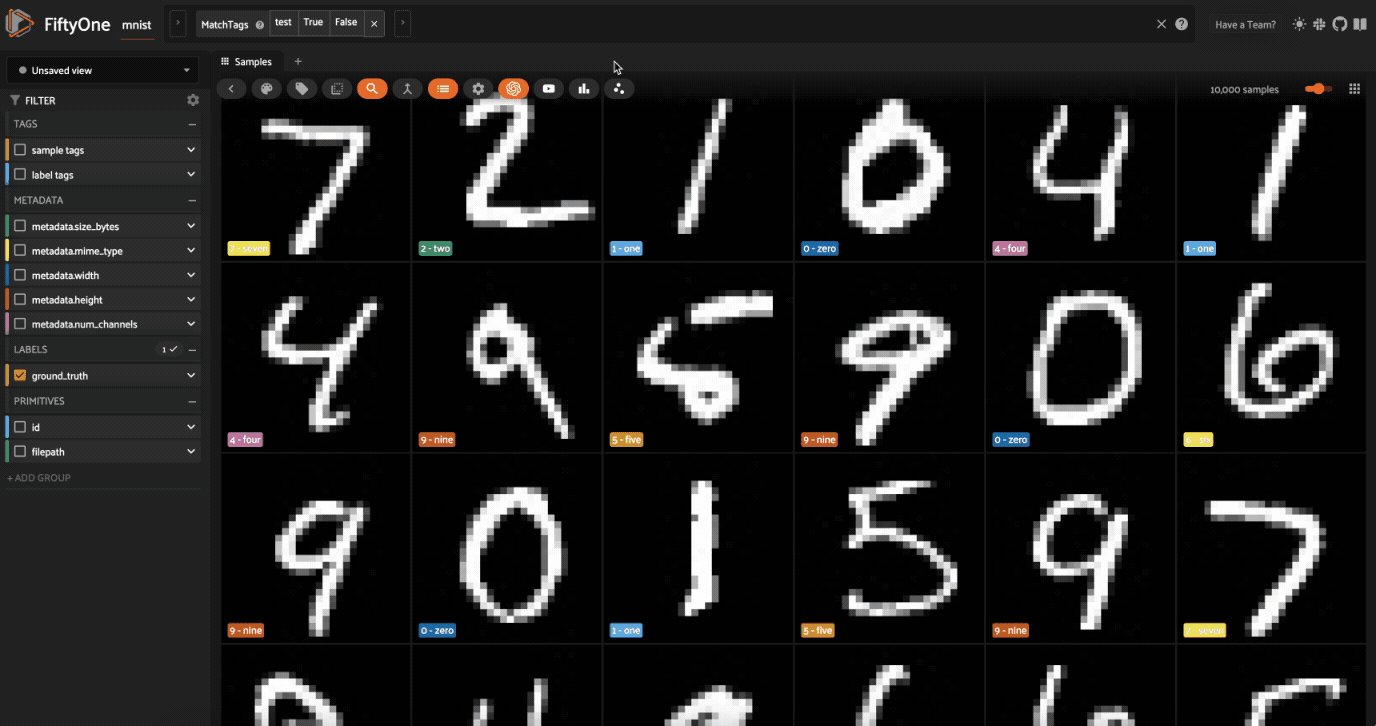

### Similitud

Fiftyone ofrece el siguiente método para indexar la similitud entre todos los vectores generados, y facilitar el análsis de los datos tanto desde el código, como desde la aplicación.

In [ ]:
bk_similarity = "bk_sim_RN18_01"

sim_results = fob.compute_similarity(
    ds,
    embeddings=embeddings,
    backend="sklearn",  # "sklearn", "qdrant", "redis", etc
    brain_key=bk_similarity,
    create_index=True,
)

**EJERCICIO 01.4**: Explique la diferencia entre el proceso que realiza *fob.compute_exact_duplicates(ds)* y el empleado en el celda anterior *fob.compute_similarity(...)*

Ingrese su respuesta 01.4 aquí: <respuesta>

Con los vectores indexados, podemos encontrar aquellos de mayor "unicidad", entendiéndolos como los que por sus características se diferencian más del resto.

In [ ]:
sim_results.find_unique(10)

In [ ]:
# Visualización de los vectores únicos en el espacio de embeddings
plot = sim_results.visualize_unique(vis_results)
plot.show(height=800, yaxis_scaleanchor="x")

In [ ]:
# Hago un freeze del plot para que no se actualice
plot.freeze()

Vamos a generar una "vista" del dataset con los datos únicos detectados para visualizarlos en el app.

In [ ]:
unique_view = ds.select(sim_results.unique_ids)
unique_view.tag_samples("unique")

uk_view_name = "unique_view"

if ds.has_saved_view(uk_view_name):
    ds.delete_saved_view(uk_view_name)

# Guardamos la vista, para cargarla más tarde desde la app
ds.save_view(uk_view_name, unique_view)

Para acceder a la vista guardada:

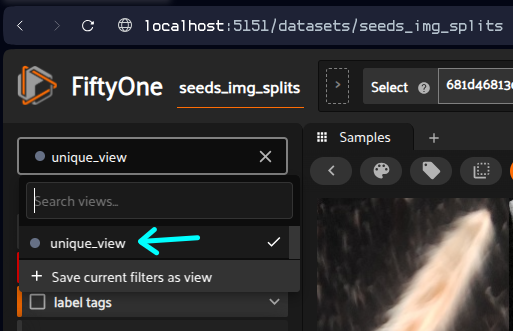

**EJERCICIO 01.5**: Utilice el método anterior de detección de unicidad de las muestras (samples), para replicar el trabajo del ejercicio 0.3: *"Selecciones el contenido de al menos cinco subdirectorios de clase, y copie las imágenes a un nuevo directorio en 'data/raw/top_5_unique_classes'."*

Aclaración: Se espera que el resultado de este ejercicio, al igual que en el ejercicio 0.3, sea un directorio con todas las imágenes correspondientes a las cinco clases más únicas, solo que en esta oportunidad en un nuevo directorio: "data/raw/top_5_unique_classes"

In [ ]:
# Ejercicio 01.5 aquí

### Unicidad

Si bien este método puede parecer idéntico a find_unique(k), existen diferencias que son necesarias considerar. Este método calcula una puntuación (score) de unicidad entre [0, 1] para una muestra respecto de todo el dataset, y la almacena en un nueva campo llamado "uniqueness". Cuánto más "única" es la muestra respecto del conjunto de datos, su valor estará más cerca de 1. Por el contrario, si la muestra comparte características con el resto de las muestras, su puntuación estará más cerca de 0.

El método visto anteriormente -find_uniquene(k)- es escencialmente un filtro donde del conjunto de entrada que obtiene son los "k" que más se diferencian del resto. He ahí también un importante diferencia: compute_uniqueness() calcula un puntaje en base a toda la entreada, mientras que find_unique(k) encuentra los k elementos más disímiles en la entrada.

En ambos casos el conjunto de entrada puede ser todo el dataset o un sobconjunto de el (vista).

In [ ]:
fob.compute_uniqueness(ds, embeddings=embeddings)

**EJERCICIO 01.6**: Obtenga y visualice en una nueva vista almacenada las 5 clases de mayor unicidad en el dataset de test bajo una nueva clave de brain para visualizarlos en la App.

In [ ]:
# Ejercicio 01.6 aquí

### Fugas

El análsisi de fugas utiliza los embeddings para detectar imágenes idénticas o muy parecidas entre los diferentes conjuntos de entrada, como por ejemplo "train", "val", y "test". Al generar un vista en base a los resultados en la App, observaremos que aparecen ordenados visualmente una muestra de "train", y luego las que se consideran parecidas de los conjuntos "val" y "test" (se recomienda activar la casilla "tags" para estos conjuntos).

De esta manera, podremos analizar, o utilizar la misma aplicación para marcar (tag) o desmarcar las muestras para moverlas a otro conjunto o decidir qué hacer con ellas luego.

In [ ]:
# Splits defined via tags
split_tags = ["train", "val", "test"]
dp_index = fob.compute_leaky_splits(ds, splits=split_tags, embeddings=embeddings, similarity_index=sim_results)
leaks = dp_index.leaks_view()

In [ ]:
lk_view_name = "leaks_view"

if ds.has_saved_view(lk_view_name):
    ds.delete_saved_view(lk_view_name)

ds.save_view(lk_view_name, leaks)

EJERCICIO 01.7: ¿Cuál es la organización en la que Fiftyone presenta las muestras en este caso? Describa cómo se presentan las muestras especificando su patrón de orden por partición (split)

Ingrese su respuesta 01.7 aquí: <respuesta>

### Casi duplicados

Utilizando los embeddings podemos generar una vista que nos permita visualizar aquellas muestras que se consideran casi duplicados de otras.

In [ ]:
dp_index = fob.compute_near_duplicates(ds, embeddings=embeddings)
dups_view = dp_index.duplicates_view()

In [ ]:
dp_view_name = "nearDuplicates_view"

if ds.has_saved_view(dp_view_name):
    ds.delete_saved_view(dp_view_name)

ds.save_view(dp_view_name, dups_view)

EJERCICIO 01.8: Explique para qué puede servir esta visualización.

Ingrese su respuesta 01.8 aquí: <respuesta>

### Representatividad

Esta función que ofrece el módulo "Brain" de fiftyone, utiliza los embeddings para formar clusters, y obtener las muestras que más representan esos clusters, por ende, observaremos las muestras que mejor representan a un conjunto de muestras similares.

In [ ]:
fob.compute_representativeness(ds, embeddings=embeddings, similarity_index=sim_results)

EJERCICIO 01.9: ¿Para qué utilizaría esta funcionalidad? ¿Qué implica que una muestra (sample) tenga un valor de representatividad cercano a 0? Ver [documentacion](https://docs.voxel51.com/brain.html#image-representativeness)

Ingrese su respuesta 01.9 aquí: <respuesta>